# Decision Trees and Random Forests: Application on feature data for H1ESC cell line in GREG.

### Author : Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)
### Last Reviewed : December 14th 2020

## Background

This notebook assesses variaegated implementations of the random forest models for the data dervied from the H1ESC cell-line in GREG. The data for the same and other cell-types for GREG is available at this <a href = "https://zenodo.org/deposit/4265559"> link</a>.

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(ggplot2))

### <a id=link3>1.2 Dataset Handling </a>

In [2]:
h1escgregStandard <- read.table("../../transcriptionFactoriesGREG/MachineLearning/data/H1ESCforML.txt", header = TRUE) ## loading data
h1escgreg <- h1escgregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(h1escgreg)

CTCF     EP300     H3K27me3 H3K36me3 H3K4me1   H3K4me2   H3K4me3 H3K9ac  
1  0.00000 0.0000000 0.000000 0.0000   0.0000000 0.0000000 0       0.000000
2  0.00000 0.0000000 0.000000 0.0000   0.0000000 0.0000000 0       0.000000
3  0.00000 0.0000000 0.000000 0.0000   0.0000000 0.0000000 0       0.000000
4  0.00000 0.0000000 0.000000 0.0000   0.0000000 0.0000000 0       0.000000
5  0.00000 0.2230824 0.000000 0.0000   0.0000000 0.0000000 0       0.000000
6 35.88248 0.3718039 1.424037 1.3575   0.7813343 0.7305773 0       1.444572
  H3K9me3   RAD21    RNA.Seq RNAPol2    YY1       Class  
1 0.0000000 0.000000 0       0.00000000 0.0000000 Non-Hub
2 0.0000000 0.000000 0       0.00000000 0.0000000 Non-Hub
3 0.0000000 0.000000 0       0.00000000 0.0000000 Non-Hub
4 0.0000000 0.000000 0       0.00000000 0.0000000 Non-Hub
5 0.0000000 0.000000 0       0.02765707 0.0000000 Non-Hub
6 0.1266057 0.279418 0       0.19359947 0.1803093 Non-Hub

In [4]:
rownames(h1escgreg) <- c()
h1escgreg$Class <- as.numeric(as.factor(h1escgreg$Class))
h1escgreg$Class <- ifelse(h1escgreg$Class == 2, 0, 1)
head(h1escgreg$Class)

[1] 0 0 0 0 0 0

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(h1escgreg), replace = TRUE, prob = c(0.8,0.2))
train <- h1escgreg[dataPartition==1,]
test <- h1escgreg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1238888 training examples and 310534 for testing.

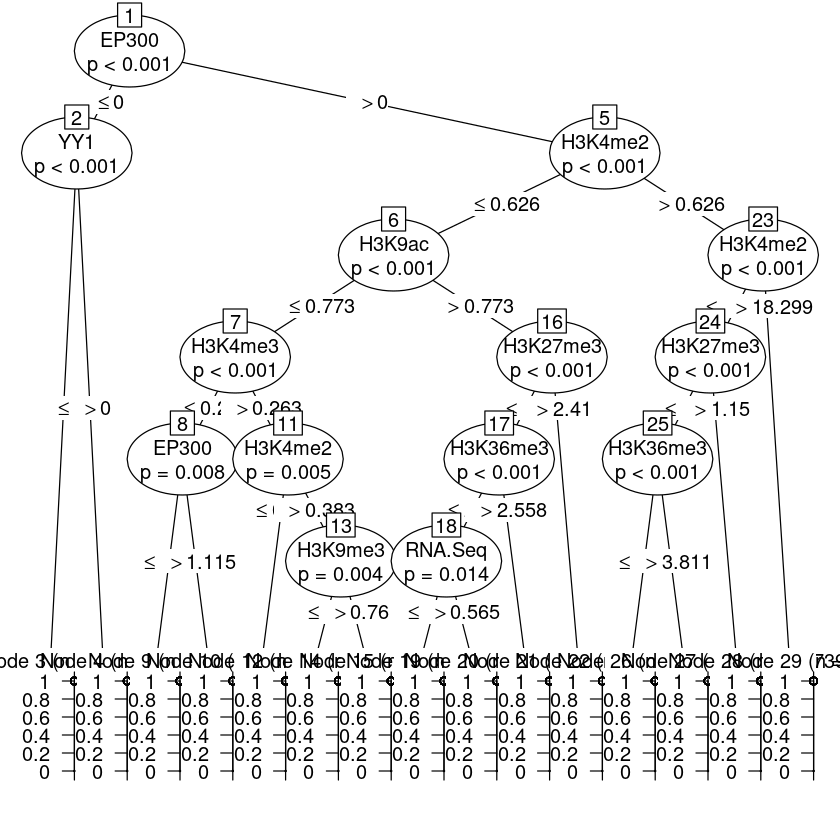

In [7]:
h1escTree <- ctree(Class ~ ., data= train)
plot(h1escTree)

The summary says that the tree has 29 overall nodes.

In [8]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(h1escTree, "rf", test, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 309655    879
The accuracy of the model is 99.71694 % 
The misclassification error of the model is 0.2830608 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(h1escTree,test)
head(ifelse(treePred > 0.5, "Hub", "Non-Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class  
[1,] Non-Hub
[2,] Non-Hub
[3,] Non-Hub
[4,] Non-Hub
[5,] Non-Hub
[6,] Non-Hub

In [10]:
treePredProb <- predict(h1escTree,test, type="prob")
head(treePredProb)

[[1]]
[1] 0.0002441749

[[2]]
[1] 0.0002441749

[[3]]
[1] 0.0002441749

[[4]]
[1] 0.0002441749

[[5]]
[1] 0.002036946

[[6]]
[1] 0.0002441749

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 7:3 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition73 <- sample(2, nrow(h1escgreg), replace = TRUE, prob = c(0.7,0.3))
train73 <- h1escgreg[dataPartition73==1,]
test73 <- h1escgreg[dataPartition73==2,]

In [12]:
cat("We have",nrow(train73),"training examples and",nrow(test73),"for testing.")

We have 1084274 training examples and 465148 for testing.

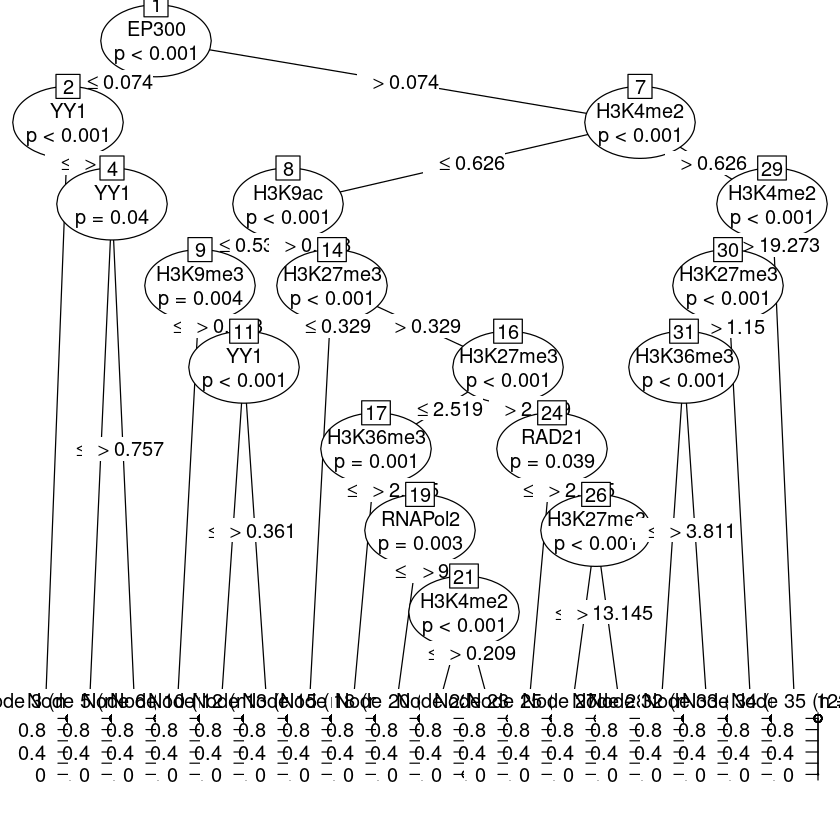

In [13]:
h1escTree73 <- ctree(Class ~ ., data= train73)
plot(h1escTree73)

In [14]:
treePred73 <- predict(h1escTree73, test73, type="response")
treePred73 <- ifelse(treePred73 > 0.5, "1", "0")

In [15]:
modelPerformance(h1escTree73, "rf", test73, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 463852   1296
The accuracy of the model is 99.72138 % 
The misclassification error of the model is 0.278621 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 1000, k = 5, perc.under = 110)
table(smoteData$Class)


    0     1 
36069 36069 

Now that the data is seemingly balanced, let's examine the performance of the model.

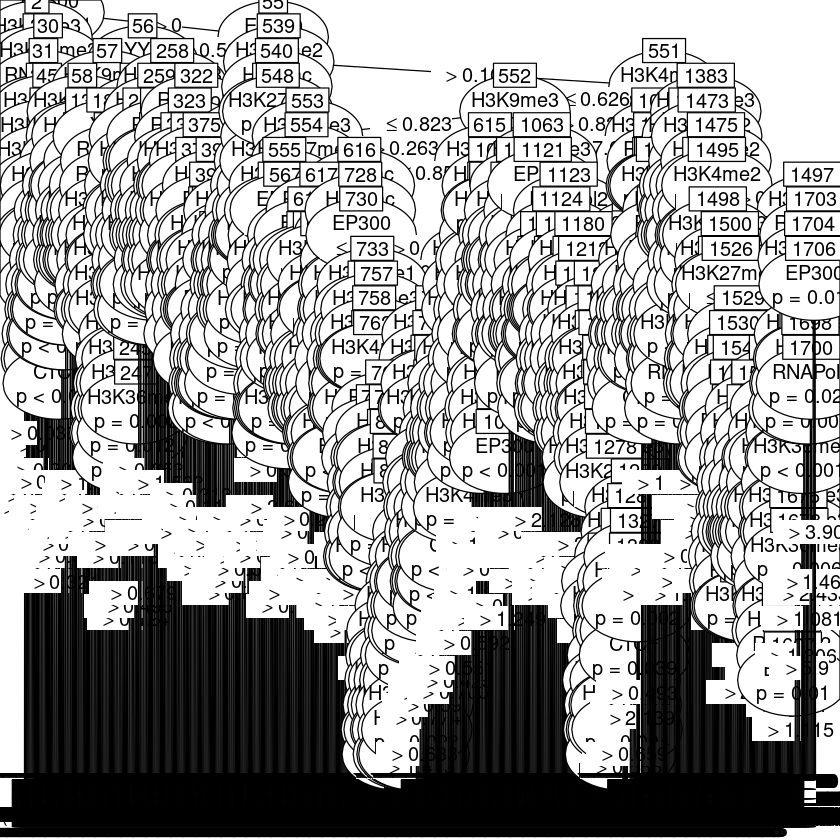

In [17]:
h1escSmoteTree <- ctree(Class ~ ., data= smoteData)
plot(h1escSmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [18]:
treeSmotePred <- predict(h1escSmoteTree, test)
head(treeSmotePred)

[1] 0 0 0 0 0 0
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0 250860    470
        1  58795    409
The accuracy of the model is 80.91513 % 
The misclassification error of the model is 19.08487 % 
The sensitivity of the model is 81.01274 % 
The specificity of the model is 46.53015 % 
The area under curve is 0.6377144 



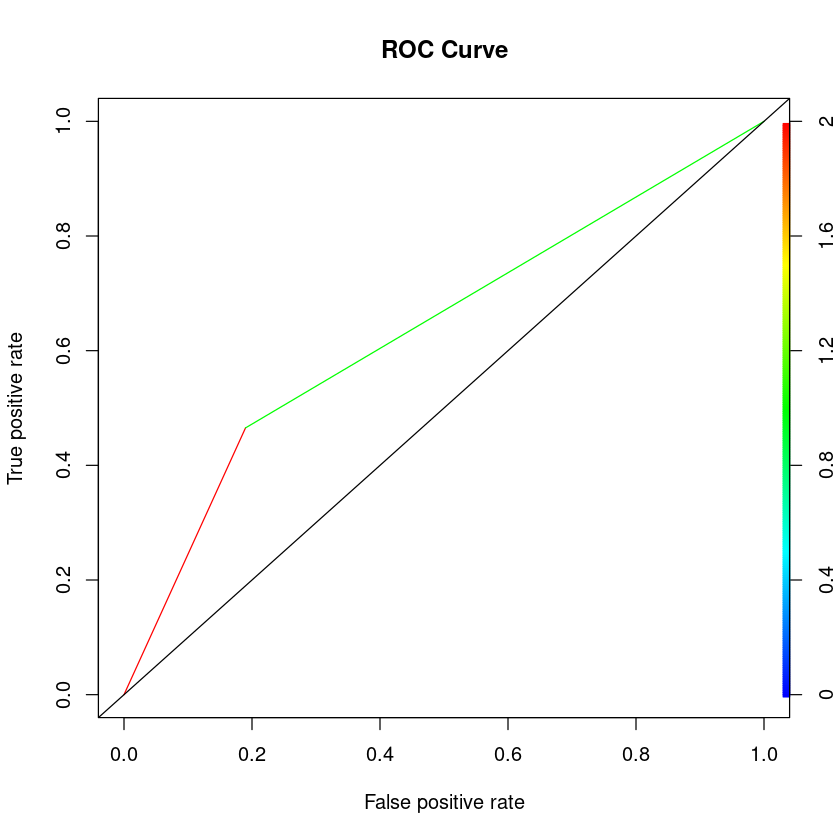

In [19]:
modelPerformance(h1escSmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Maybe, we should explore other options.

<p align="justify"> Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ). </p>

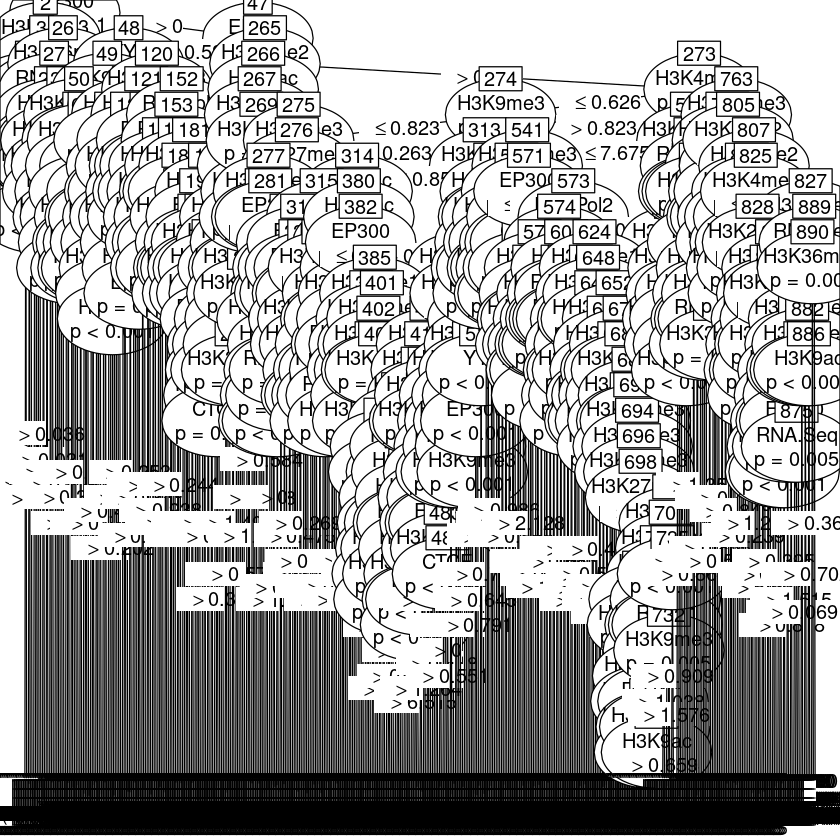

In [20]:
h1escSmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(h1escSmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 230539    428
        1  79116    451
The accuracy of the model is 74.38477 % 
The misclassification error of the model is 25.61523 % 
The sensitivity of the model is 74.45028 % 
The specificity of the model is 51.3083 % 
The area under curve is 0.6287929 



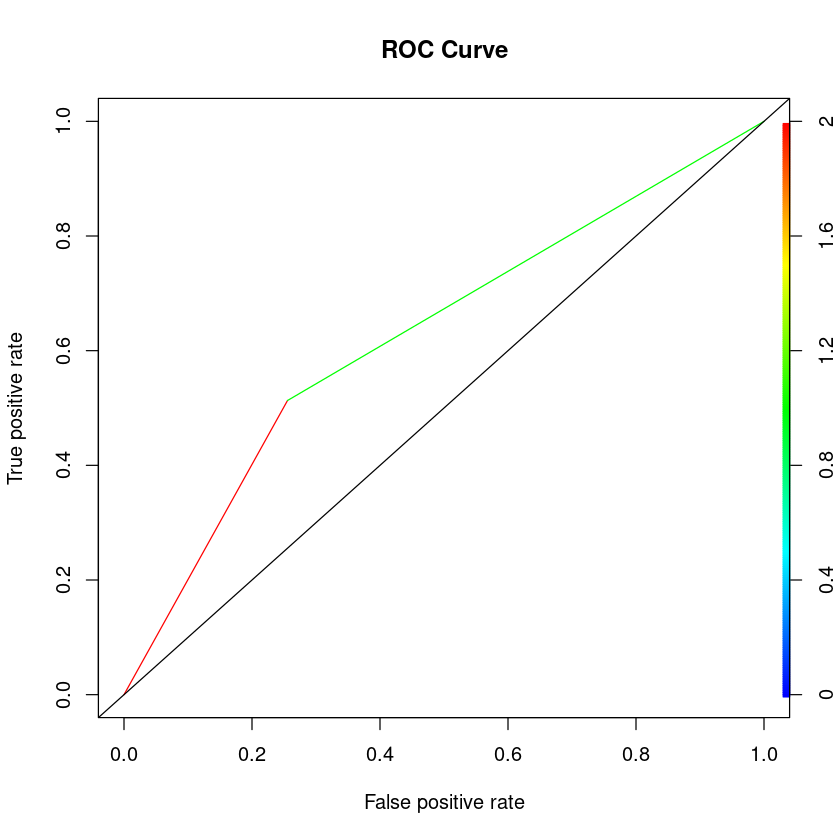

In [21]:
modelPerformance(h1escSmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

This model is rated lesser in terms of accuracy than the previous model, and the AUC has shrunk infinitesimally.

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [22]:
h1escTreeAlt <- rpart(Class ~ ., data = smoteData)

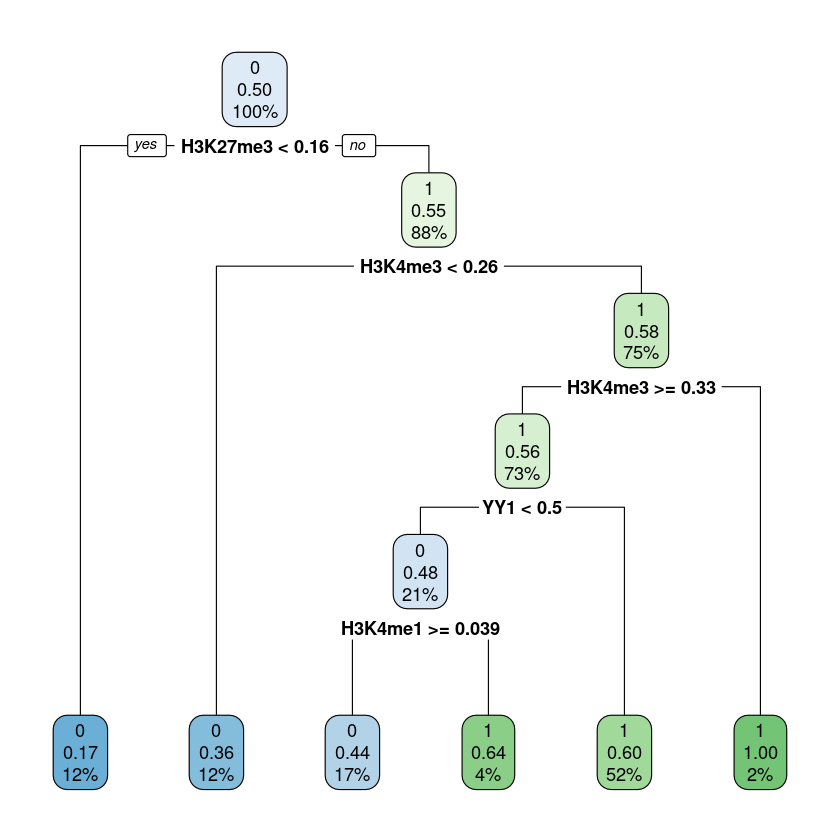

In [23]:
rpart.plot(h1escTreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [24]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
h1escgregSample <- h1escgreg[sample(nrow(h1escgreg), replace=T, size=0.1*nrow(h1escgreg)),]

## Making thr response variable a 'factor', since we are attempting classification.

h1escgregSample$Class <- as.factor(h1escgregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(h1escgregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- h1escgregSample[dataPartition73 == 1,]
test73 <- h1escgregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [25]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    0     1 
53948 54321 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [26]:
# Execute random forest algorithm

h1escrf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(h1escrf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 0%
Confusion matrix:
      0     1  class.error
0 53945     3 5.560911e-05
1     0 54321 0.000000e+00


In [27]:
# Prediction and Confusion Matrix

h1escPredRF <- predict(h1escrf,test73)
confusionMatrix(h1escPredRF, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 46542   109
         1     0    22
                                          
               Accuracy : 0.9977          
                 95% CI : (0.9972, 0.9981)
    No Information Rate : 0.9972          
    P-Value [Acc > NIR] : 0.02734         
                                          
                  Kappa : 0.287           
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.1679389       
            Specificity : 1.0000000       
         Pos Pred Value : 1.0000000       
         Neg Pred Value : 0.9976635       
             Prevalence : 0.0028068       
         Detection Rate : 0.0004714       
   Detection Prevalence : 0.0004714       
      Balanced Accuracy : 0.5839695       
                                          
       'Positive' Class : 1               
                  

Despite the high accuracy of the model at 99.7 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (100 %). 

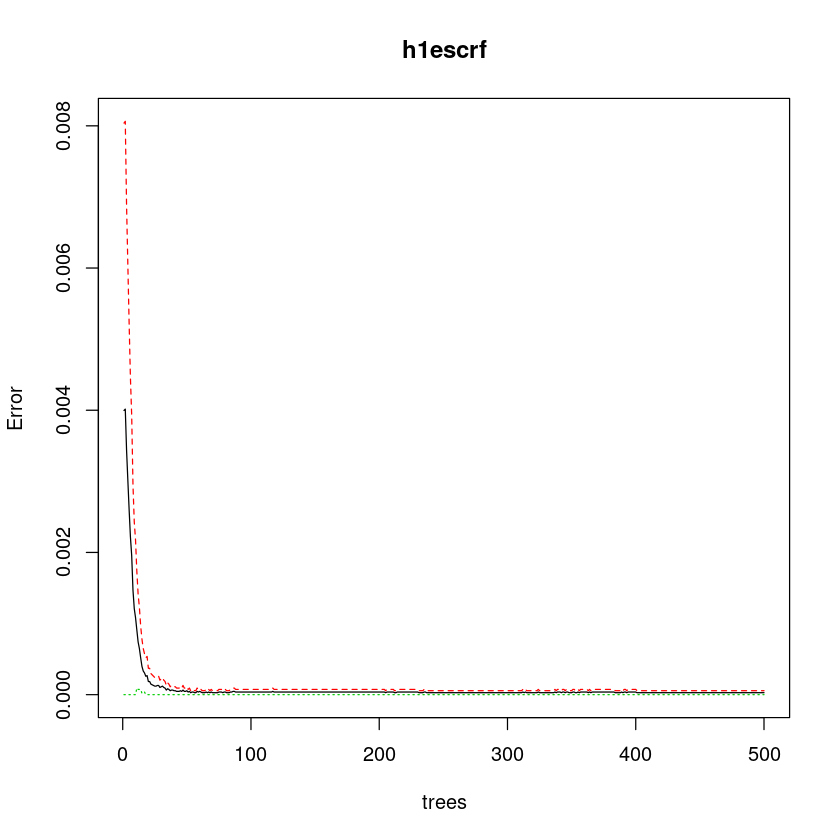

In [28]:
# Error rates (MSEs) of the Random Forest

plot(h1escrf)

The above plot shows that the error rate stablises after ~50 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 50. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [29]:
head(bothTrain)

CTCF      EP300     H3K27me3   H3K36me3  H3K4me1   H3K4me2   H3K4me3  
1 0.2268992 0.2974431 0.05477066 0.0000000 0.3906671 0.1043682 0.3288485
2 0.3565558 0.2974431 0.16431198 2.2450959 0.3516004 0.1043682 0.2630788
3 0.3565558 0.6692471 0.43816527 0.5221153 0.2734670 0.5566304 0.7234667
4 0.1944850 0.5948863 0.43816527 0.4699038 0.1953336 0.2783152 0.4603879
5 0.2593133 0.4461647 0.27385329 0.8875960 0.3516004 0.4870516 0.5261576
6 0.1296567 0.2230824 0.32862395 0.7831730 0.2344003 0.3131046 0.3946182
  H3K9ac    H3K9me3   RAD21     RNA.Seq RNAPol2   YY1       Class
1 0.2351628 0.3798172 0.2794180 0       0.2765707 0.3606186 0    
2 0.6382991 0.4431201 0.6209290 0       0.0000000 0.0000000 0    
3 0.3695416 0.7912858 0.8382541 0       0.5254843 0.5769897 0    
4 0.4031363 0.8862401 0.6209290 0       0.2765707 0.5769897 0    
5 0.1679734 0.7279829 0.5588361 0       0.3042277 0.1803093 0    
6 0.4703256 0.7912858 0.1241858 0       0.1935995 0.4688041 0

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 2 	OOB error = 0.06% 
-21.33333 0.005 
Searching right ...
mtry = 6 	OOB error = 0.01% 
-1.333333 0.005 


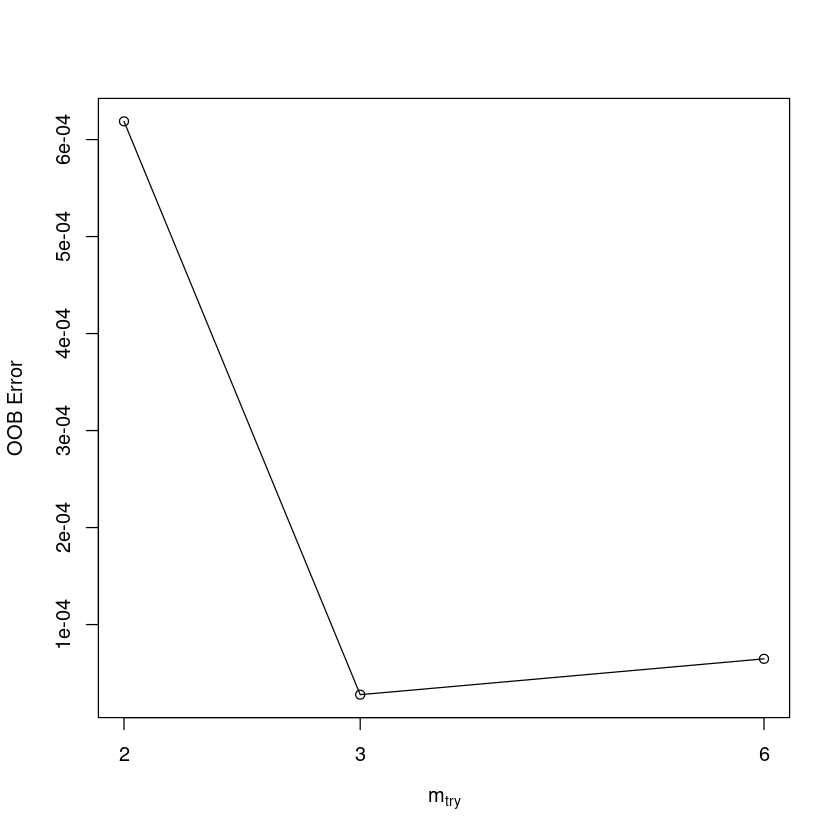

In [30]:
# Tuning mtry

t2 <- tuneRF(bothTrain[,-14], bothTrain[,14],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 50,
            trace = TRUE,
            improve = 0.005)               

At *mtry*=3, there is no error. To confirm, let us increase the step factor value and try again.

mtry = 3  OOB error = 0.01% 
Searching left ...
mtry = 1 	OOB error = 0.76% 
-136.8333 0.005 
Searching right ...
mtry = 13 	OOB error = 0.03% 
-4 0.005 


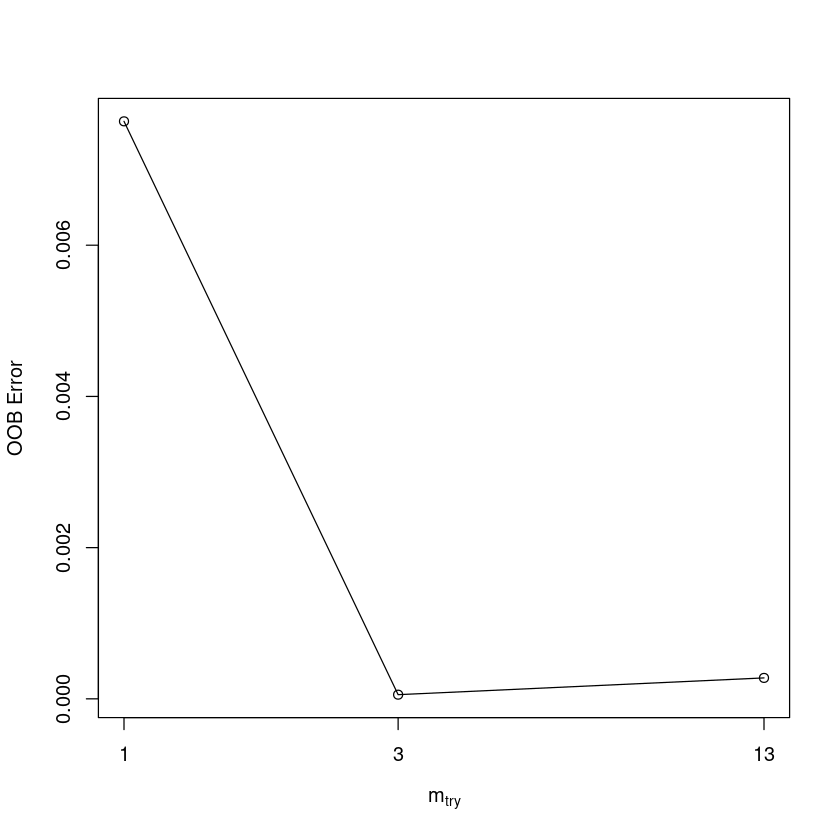

In [31]:
# Tuning with stepfactor = 5

t5 <- tuneRF(bothTrain[,-14], bothTrain[,14],
            stepFactor = 5,
            plot = TRUE,
            ntreeTry = 50,
            trace = TRUE,
            improve = 0.005)      

mtry = 3  OOB error = 0% 
Searching left ...
mtry = 1 	OOB error = 0.56% 
-120.6 0.005 
Searching right ...
mtry = 12 	OOB error = 0.03% 
-4.6 0.005 


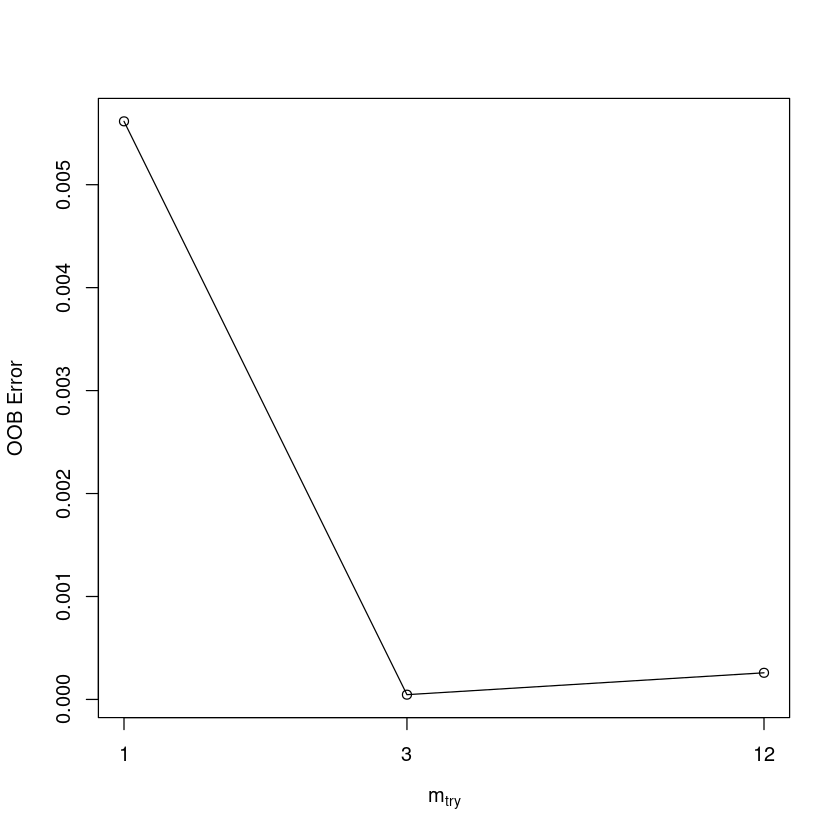

In [32]:
# Tuning with stepfactor = 4

t4 <- tuneRF(bothTrain[,-14], bothTrain[,14],
            stepFactor = 4,
            plot = TRUE,
            ntreeTry = 50,
            trace = TRUE,
            improve = 0.005)    

Thus, we see that with *stepfactor = 5,4* no new values of mtry emerge.

We observe that OOB error stablises on assuming the random sample size of 3. This is the optimal value for *mtry* parameter. With the modified values of *mtry* and *ntree*, let us attempt our new Random Forest model. It will hopefully be an improved one.

However, owing to the biasness in the model to predict negative class over positive class, let's make an attempt with *smoteData* flavor and examine any improvement; we did consider balanced samples in *bothTrain* though.

In [33]:
# Execute random forest algorithm

h1escrf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 50)
print(h1escrf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 50) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.68%
Confusion matrix:
      0     1 class.error
0 35575   494  0.01369597
1  1441 34628  0.03995120


The confusion matrix is
         Actual
Predicted      0      1
        0 307388    417
        1   2267    462
The accuracy of the model is 99.13568 % 
The misclassification error of the model is 0.8643176 % 
The sensitivity of the model is 99.26789 % 
The specificity of the model is 52.55973 % 
The area under curve is 0.7591381 



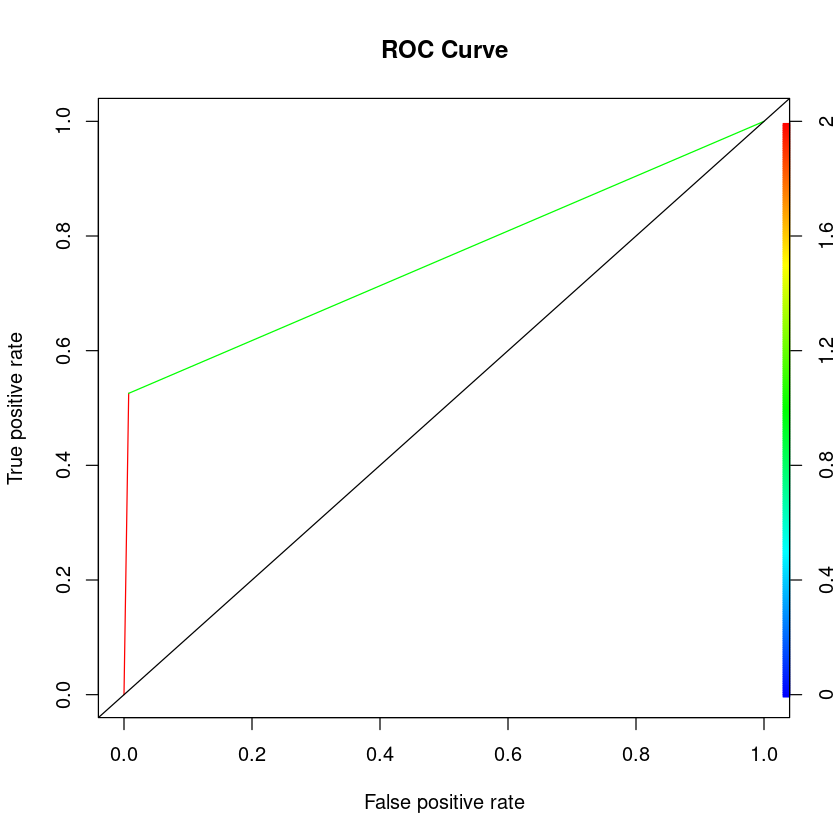

In [34]:
modelPerformance(h1escrf1, "rf", test, Class)

For sure, this is way better than the previous one, with given improved estimate of sensitivity. We can observe the SMOTE transformation has a positive effect on the model's performance in making predictions for the minority class instances.

In [35]:
h1escPredRFOpt <- predict(h1escrf1,test73)
confusionMatrix(h1escPredRFOpt, test73$Class, positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 46201    19
         1   341   112
                                          
               Accuracy : 0.9923          
                 95% CI : (0.9915, 0.9931)
    No Information Rate : 0.9972          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3809          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.854962        
            Specificity : 0.992673        
         Pos Pred Value : 0.247241        
         Neg Pred Value : 0.999589        
             Prevalence : 0.002807        
         Detection Rate : 0.002400        
   Detection Prevalence : 0.009706        
      Balanced Accuracy : 0.923818        
                                          
       'Positive' Class : 1               
                  

The model performs well with the 70:30 data too.

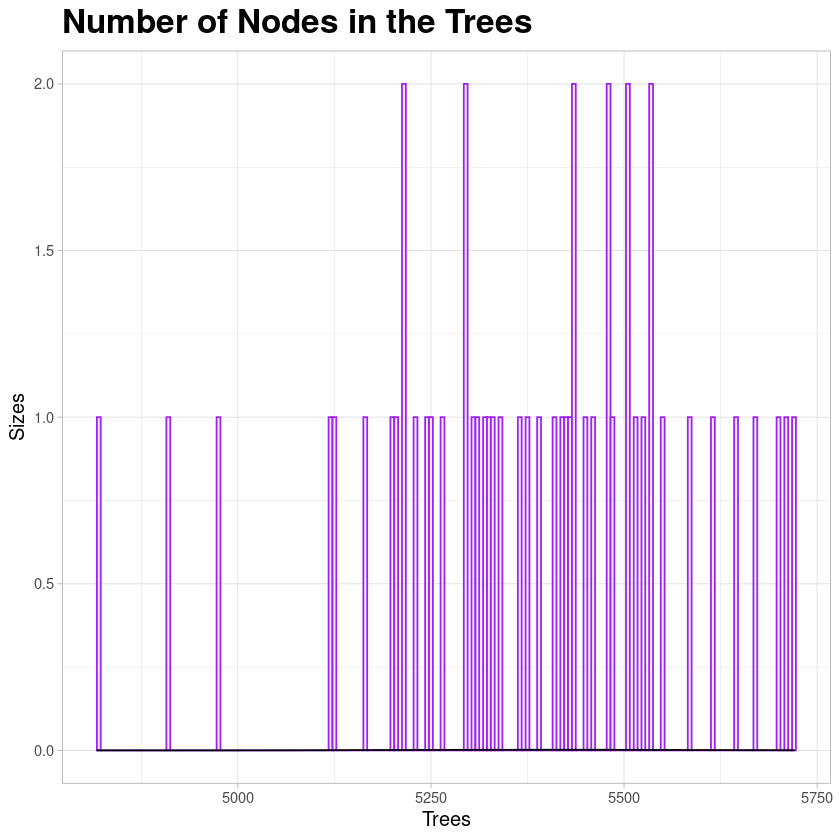

In [36]:
# Number of nodes for the trees

ts <- as.data.frame(treesize(h1escrf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(h1escrf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

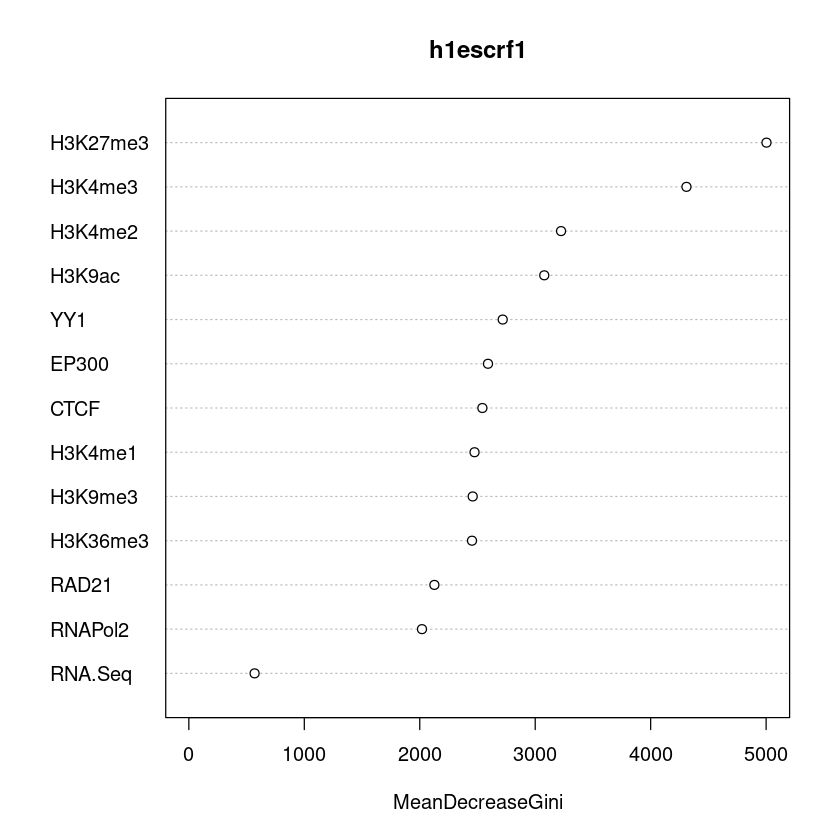

In [37]:
# Variable Importance

varImpPlot(h1escrf1)

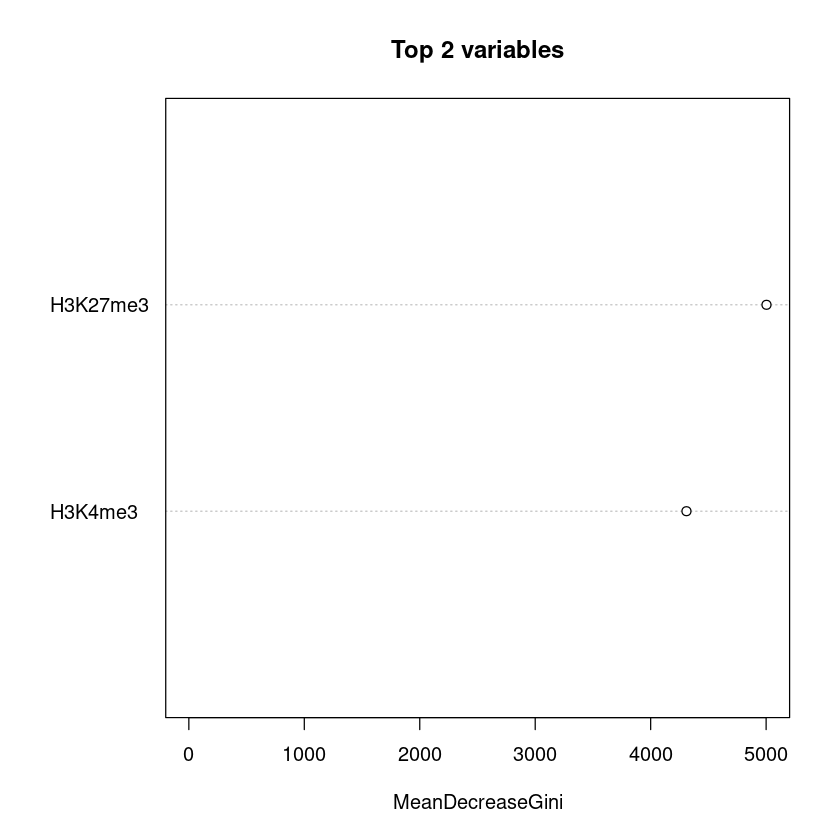

In [38]:
varImpPlot(h1escrf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [39]:
importance(h1escrf1)

MeanDecreaseGini
CTCF     2542.5465       
EP300    2591.0395       
H3K27me3 5003.2195       
H3K36me3 2452.4956       
H3K4me1  2474.4178       
H3K4me2  3223.9022       
H3K4me3  4310.0214       
H3K9ac   3078.3634       
H3K9me3  2458.6328       
RAD21    2126.7013       
RNA.Seq   569.5407       
RNAPol2  2019.2448       
YY1      2718.4796

In [40]:
varUsed(h1escrf1)

[1] 23484 22051 22000 22386 22610 23130 21818 23620 21988 21113  4292 19795
[13] 20476

This classification model of random forests projects **H3K27me3** as the most crucial variable with maximum instances used while contruction of trees.

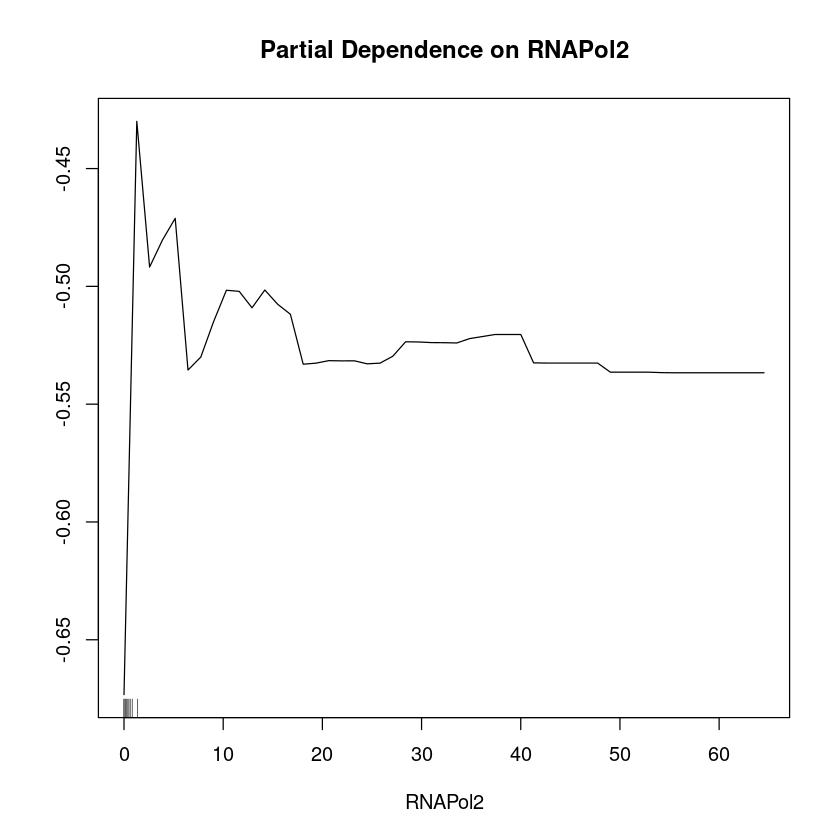

In [41]:
# Partial Dependence Plots

partialPlot(h1escrf1, smoteData, RNAPol2 , "1")

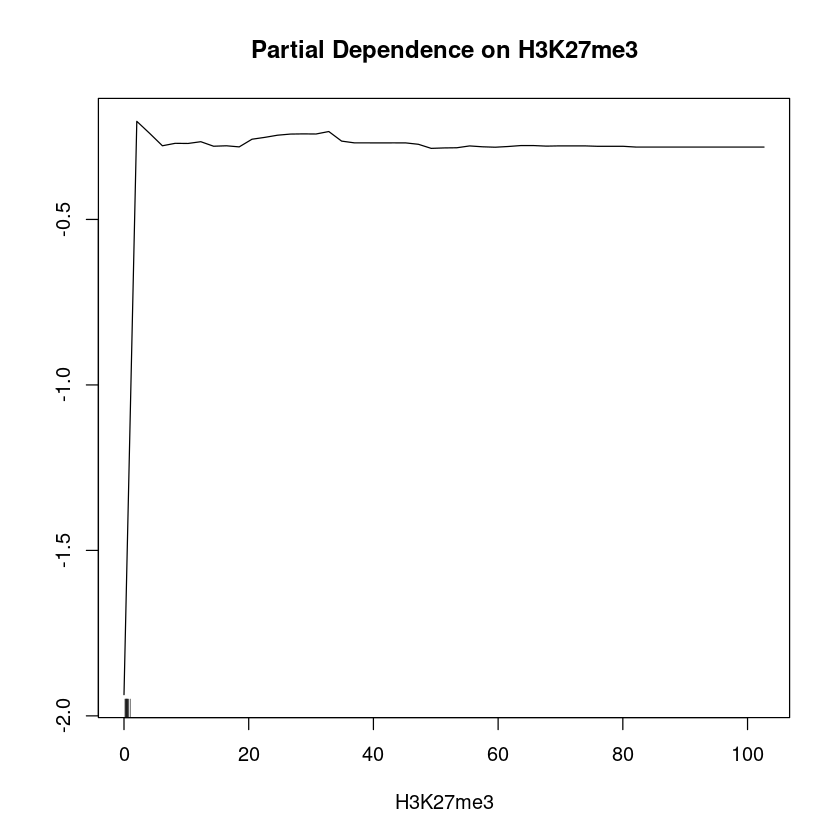

In [42]:
partialPlot(h1escrf1, smoteData, H3K27me3, "1")

The partial dependence plot represents a variable's contribution to the probability of class depiction (classification). The variable contribution of H3K27me3 is high and regular. Contrarily, as seen below, CTCF has important contribution to the model but at a lower scale.

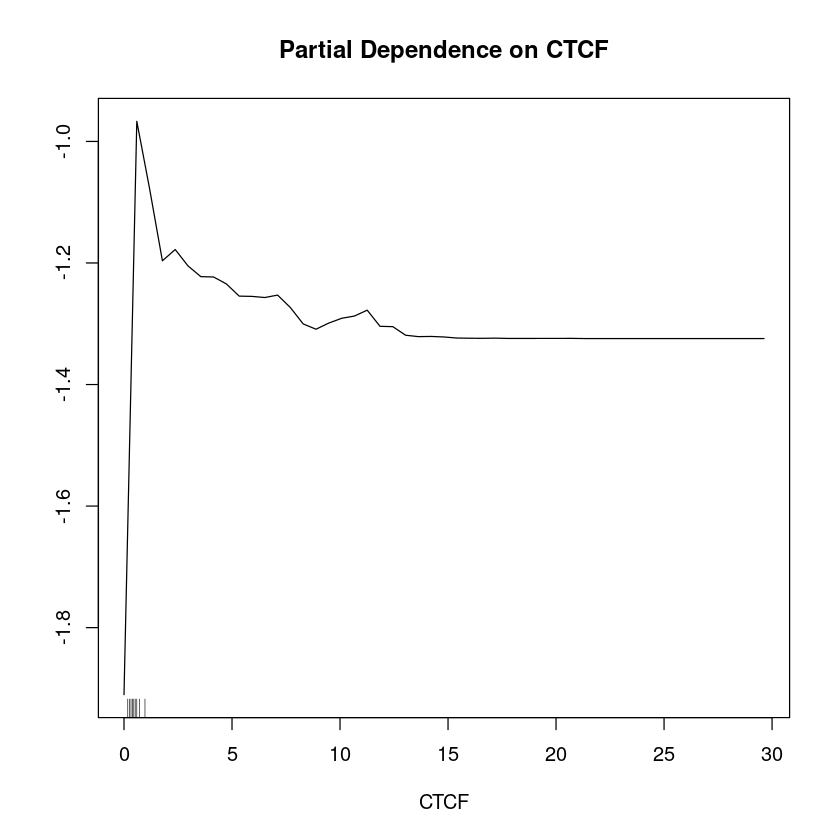

In [43]:
partialPlot(h1escrf1, smoteData, CTCF, "1")

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [44]:
h1escgregModelPredictions <- predict(h1escrf1, h1escgreg, type = "response")
h1escgregModelPredictionsProbs <- as.factor(h1escgregModelPredictions)

In [45]:
head(h1escgregModelPredictionsProbs)

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the H1ESC cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [46]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

Next, we recall the data from the H1ESC cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [47]:
h1escgregStandardRegionsClass <- h1escgregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [48]:
## Extracting chr21 data

h1escgregChr21NonHub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
h1escgregChr21Hub <- h1escgregStandardRegionsClass[h1escgregStandardRegionsClass$chr=="chr21" & h1escgregStandardRegionsClass$Class=="Hub", ]

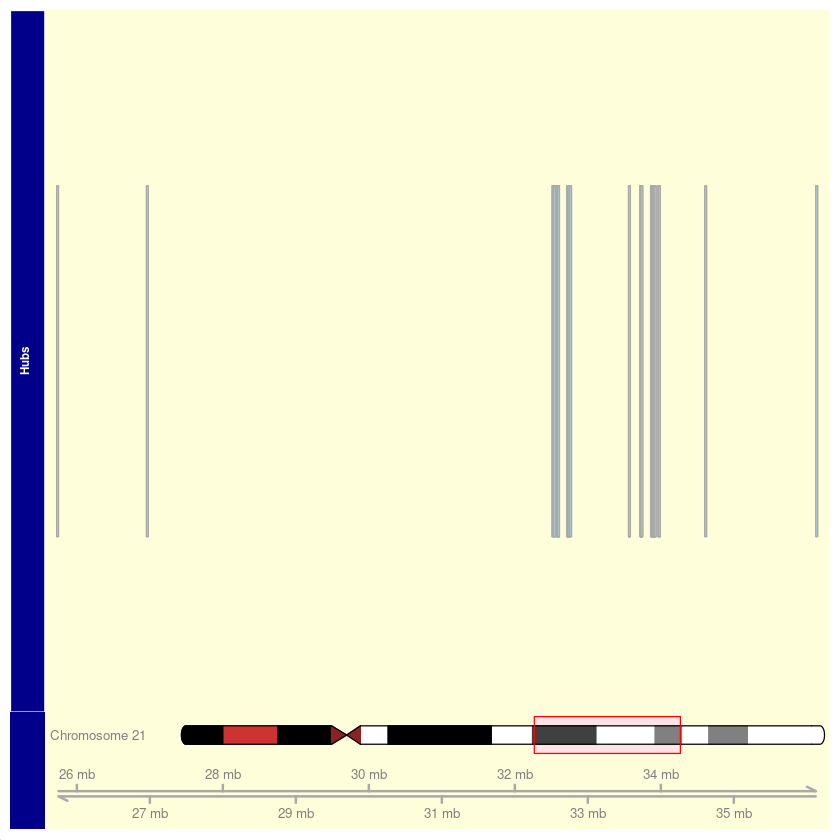

In [49]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [50]:
print(h1escgregChr21Hub)

         chr    start      end Class
810340 chr21 25734001 25736000   Hub
810341 chr21 25736001 25738000   Hub
810955 chr21 26964001 26966000   Hub
810956 chr21 26966001 26968000   Hub
813733 chr21 32520001 32522000   Hub
813734 chr21 32522001 32524000   Hub
813742 chr21 32538001 32540000   Hub
813743 chr21 32538001 32540000   Hub
813744 chr21 32540001 32542000   Hub
813745 chr21 32540001 32542000   Hub
813746 chr21 32542001 32544000   Hub
813747 chr21 32542001 32544000   Hub
813748 chr21 32544001 32546000   Hub
813749 chr21 32544001 32546000   Hub
813769 chr21 32584001 32586000   Hub
813770 chr21 32584001 32586000   Hub
813771 chr21 32586001 32588000   Hub
813772 chr21 32586001 32588000   Hub
813773 chr21 32588001 32590000   Hub
813774 chr21 32588001 32590000   Hub
813775 chr21 32590001 32592000   Hub
813776 chr21 32590001 32592000   Hub
813777 chr21 32592001 32594000   Hub
813778 chr21 32592001 32594000   Hub
813779 chr21 32594001 32596000   Hub
813780 chr21 32594001 32596000   Hub
8

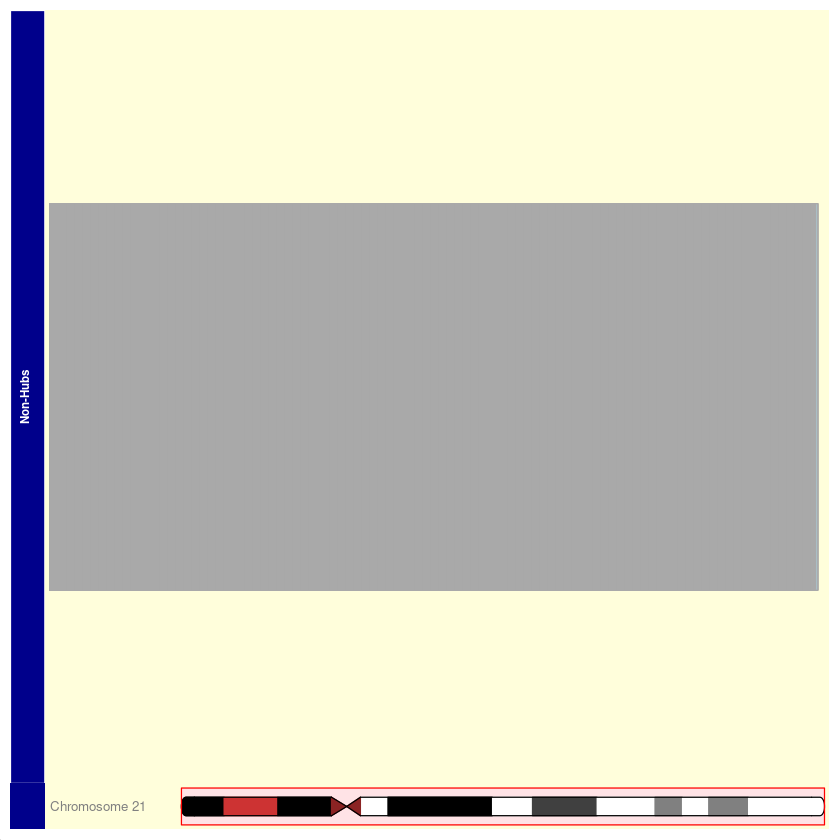

In [51]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = h1escgregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [52]:
h1escgregPredicted <- cbind(h1escgregStandardRegionsClass, h1escgregModelPredictionsProbs)
names(h1escgregPredicted)[names(h1escgregPredicted) == "h1escgregModelPredictionsProbs"] <- "Prediction"
h1escgregPredicted$Prediction <- ifelse(h1escgregPredicted$Prediction == 1, "Hub", "Non-Hub")  

Let us see if the classifier predictions match with the original results.

In [53]:
h1escgregChr21PredicitedHub <- h1escgregPredicted[h1escgregPredicted$chr=="chr21" & h1escgregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

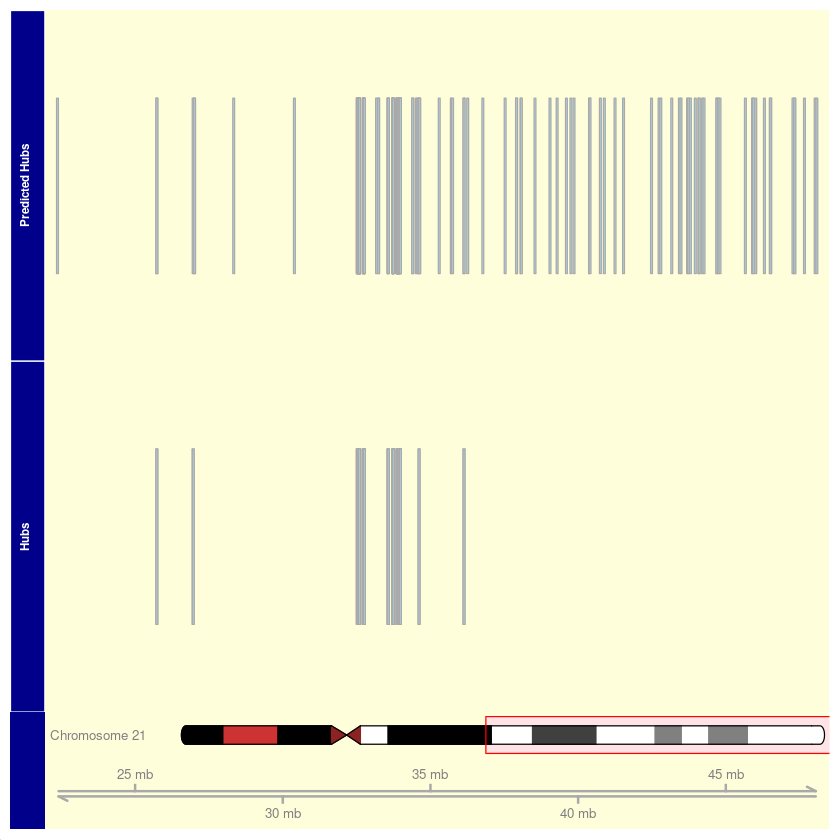

In [54]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = h1escgregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = h1escgregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [55]:
truePositives <- h1escgregPredicted[h1escgregPredicted$Class == h1escgregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [56]:
## Saving relevant files

save(h1escrf1, file = "./optimalModels/h1escmodelRF") # optimal model
write.table(truePositives, file = "./truePositives/h1escRF.txt", quote = FALSE) # true positives: precicted ~ original
write.table(smoteData, file = "./buildData/optimalModelTrainH1ESCRF.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestH1ESCRF.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| h1escrf1 | 99.13568 % | 99.26789 % | 52.55973 % | Fair

Also, note that data on which the model was trained has a distribution of 36069:36069 = 1 in class proportion. So, the probability of finding any class is 50% (ideally) because we have a homogeneous spread of class labels. Despite since the model has higher sensitivity, i.e. higher knack for predicting positive classes, the performance could be considered fair, despite of higher accuracy. In addition, we observe that the model has a moderate specificity. This symbolises that the negative classes are also marked considerably well.   

##  <a id=link11>4. Session Information </a>

In [70]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         ggplot2_3.3.2       
[10] e1071_1.7-3          ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l